In [8]:
import torch
import torch.nn as nn

import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#Vocab


NOTE_SIZE = 128
DUR_SIZE = 160
TIM_SIZE = 1000
VEL_SIZE = 128


NOTE_TOKS = [f'n{i}' for i in range(NOTE_SIZE)] 
DUR_TOKS = [f'd{i}' for i in range(DUR_SIZE)]
TIM_TOKS = [f't{i}' for i in range(TIM_SIZE)]
VEL_TOKS = [f'v{i}' for i in range(VEL_SIZE)]

BOS_TOK = "BOS"
# Le token dummy sert seulement à initialiser les mots du vocab à partir de l'index 1, conformément aux prérequis de la fonction vocab()
VOCAB = ["dummy"] + [BOS_TOK] + NOTE_TOKS + DUR_TOKS + TIM_TOKS + VEL_TOKS 

DICT = [(element, index) for index, element in enumerate(VOCAB)]


In [10]:
from torchtext.vocab import vocab
from collections import OrderedDict

custom_vocab = vocab(OrderedDict(DICT))
itos_vocab = custom_vocab.get_itos()

In [11]:
import numpy as np
from tqdm import tqdm
from music21 import *
import os


# Load the MIDI file
midi_file = midi.MidiFile()

les_tokens = []

# Dossier contenant les fichiers MIDI pour l'entraînement
folder_path = "train_data"  

# Get all the file names in the folder
file_names = os.listdir(folder_path)
for f in tqdm(file_names):
    print(f)
    midi_file = midi.MidiFile()
    midi_file.open(folder_path + "/" +f)
    midi_file.read()
    midi_file.close()
    # Create a stream from the MIDI file
    stream = midi.translate.midiFileToStream(midi_file)

    # Iterate over the notes in the stream and extract the note information
    last_time = 0

    for note in stream.flat.notes:
        if note.isNote:
            note_pitch = note.pitch.midi
            # A terme il faudra arrondir plutot que de prendre la partie entiere
            note_duration = int(note.duration.quarterLength*4)
            note_offset = int(note.offset*4 - last_time)
            last_time = note.offset*4
            note_velocity = note.volume.velocity
            les_tokens.append(NOTE_TOKS[note_pitch])
            les_tokens.append(DUR_TOKS[note_duration])
            if note_offset < NOTE_SIZE:
                les_tokens.append(TIM_TOKS[note_offset])
            les_tokens.append(VEL_TOKS[note_velocity])

        if note.isChord:

            for note2 in note:
                note_pitch = note2.pitch.midi
                note_duration = int(note.duration.quarterLength*4)
                note_offset = int(note.offset*4 - last_time)
                last_time = note.offset*4
                note_velocity = note2.volume.velocity
                les_tokens.append(NOTE_TOKS[note_pitch])
                les_tokens.append(DUR_TOKS[note_duration])
                if note_offset < NOTE_SIZE:
                    les_tokens.append(TIM_TOKS[note_offset])
                les_tokens.append(VEL_TOKS[note_velocity])
          


  0%|          | 0/16 [00:00<?, ?it/s]

ArtPepper_Anthropology_FINAL.mid


  6%|▋         | 1/16 [00:00<00:04,  3.05it/s]

ArtPepper_BluesForBlanche_FINAL.mid


 19%|█▉        | 3/16 [00:00<00:04,  3.19it/s]

ArtPepper_Desafinado_FINAL.mid
ArtPepper_InAMellowTone_FINAL.mid


 25%|██▌       | 4/16 [00:01<00:03,  3.05it/s]

ArtPepper_Stardust-1_FINAL.mid


 31%|███▏      | 5/16 [00:02<00:08,  1.28it/s]

ArtPepper_Stardust-2_FINAL.mid


 38%|███▊      | 6/16 [00:05<00:14,  1.48s/it]

BennyCarter_IGotItBad_FINAL.mid


 44%|████▍     | 7/16 [00:07<00:14,  1.65s/it]

BennyCarter_It'sAWonderfulWorld-1_FINAL.mid


 56%|█████▋    | 9/16 [00:09<00:07,  1.12s/it]

BennyCarter_It'sAWonderfulWorld-2_FINAL.mid
BennyCarter_JustFriends_FINAL.mid


 69%|██████▉   | 11/16 [00:09<00:03,  1.46it/s]

BennyCarter_LongAgoAndFarAway-1_FINAL.mid
BennyCarter_LongAgoAndFarAway-2_FINAL.mid


 75%|███████▌  | 12/16 [00:10<00:02,  1.81it/s]

BennyCarter_SweetLorraine_FINAL.mid


 88%|████████▊ | 14/16 [00:11<00:00,  2.09it/s]

BennyGoodman_Avalon_FINAL.mid
BennyGoodman_HandfulOfKeys_FINAL.mid
BennyGoodman_Nobody'sSweetheart_FINAL.mid


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


In [12]:
#répartir le data du morceau en blocs de 120 attributs (30 notes)
#Et associer à chaque bloc la réponse attendue (l'attribut suivant)

taille_bloc = 120
les_morceaux = []
les_morceaux_rep = []

for i in range(len(les_tokens)//(taille_bloc+1)-1):
    les_morceaux.append(les_tokens[i:i+taille_bloc-1])
    les_morceaux_rep.append(les_tokens[i:i+taille_bloc])



input_vect = [ [0] + [ custom_vocab[tok] for tok in morceau] for morceau in les_morceaux ]
rep_vect = [ [ custom_vocab[tok] for tok in morceau] for morceau in les_morceaux_rep ]

In [13]:
print(input_vect[0])
print(rep_vect[0])


[0, 66, 131, 1393, 64, 131, 293, 1398, 59, 130, 292, 1392, 62, 132, 291, 1393, 64, 131, 293, 1403, 59, 131, 294, 1395, 59, 136, 293, 1387, 51, 131, 328, 1379, 58, 131, 293, 1402, 61, 130, 291, 1399, 59, 131, 290, 1400, 56, 130, 292, 1392, 59, 130, 292, 1395, 62, 133, 290, 1395, 61, 131, 294, 1401, 59, 130, 291, 1389, 61, 134, 291, 1394, 59, 131, 295, 1398, 57, 131, 291, 1396, 61, 131, 291, 1395, 60, 130, 291, 1390, 58, 130, 291, 1392, 59, 131, 290, 1400, 55, 131, 291, 1391, 56, 130, 291, 1386, 59, 130, 290, 1398, 62, 131, 290, 1396, 57, 130, 292, 1392, 62, 131, 290, 1402, 63, 130, 291, 1403]
[66, 131, 1393, 64, 131, 293, 1398, 59, 130, 292, 1392, 62, 132, 291, 1393, 64, 131, 293, 1403, 59, 131, 294, 1395, 59, 136, 293, 1387, 51, 131, 328, 1379, 58, 131, 293, 1402, 61, 130, 291, 1399, 59, 131, 290, 1400, 56, 130, 292, 1392, 59, 130, 292, 1395, 62, 133, 290, 1395, 61, 131, 294, 1401, 59, 130, 291, 1389, 61, 134, 291, 1394, 59, 131, 295, 1398, 57, 131, 291, 1396, 61, 131, 291, 1395, 60, 1

In [14]:
from torch.utils.data import Dataset, DataLoader

batch_size = 32

# Define the dataset
class MyDataset(Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        input_tensor = torch.tensor(self.input_data[idx], dtype=torch.long)
        output_tensor = torch.tensor(self.output_data[idx], dtype=torch.long)
        return input_tensor, output_tensor

# Load the dataset

dataset = MyDataset(input_vect, rep_vect)


# Create a dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [16]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/p/c80afbc9ffb1/
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
            batch_first = True
        )
        self.out = nn.Linear(dim_model, num_tokens)
        '''
        Créer les 3 autres out
        '''
    # A modifier pour utiliser 4 out functions différentes selon les cas    
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out

    # Genere un masque triangulaire  
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    # Le pad mask sera utile quand on aura ajouté les PAD tokens
    # def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
    #     # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
    #     # [False, False, False, True, True, True]
    #     return (matrix == pad_token)

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens=len(custom_vocab), dim_model=512, num_heads=8, num_encoder_layers=1, num_decoder_layers=4, dropout_p=0.1
).to(device)


model_file = "modelRAS.pth"

# Load the pre-trained model
state_dict = torch.load(model_file, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
#On met le model en mode eval
model.eval()



opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [35]:
torch.cuda.is_available() 

True

In [19]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    

    # Entraîner le modèle sur une boucle

    for batch in dataloader:
        y_input, y_expected = batch

        # X est ce qu'on donne à l'encoder. Un vecteur nul dans notre cas en l'absence d'informations contextuelles
        X = torch.tensor([0]*len(y_input)).to(device)
        X, y_input, y_expected = X.clone().detach().to(device) , y_input.clone().detach().to(device) , y_expected.clone().detach().to(device) 

        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(0, 2, 1)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [ ]:
def fit(model, opt, loss_fn, train_dataloader, epochs):
    # Used for plotting later on
    train_loss_list= []
    
    print("Training model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        #validation_loss = validation_loop(model, loss_fn, val_dataloader)
        #validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        #print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list#, validation_loss_list
    
train_loss_list = fit(model, opt, loss_fn, dataloader, 10)

Training model
------------------------- Epoch 1 -------------------------
Training loss: 3.9935

------------------------- Epoch 2 -------------------------
Training loss: 3.0139

------------------------- Epoch 3 -------------------------
Training loss: 2.6948

------------------------- Epoch 4 -------------------------
Training loss: 2.5377

------------------------- Epoch 5 -------------------------
Training loss: 2.4527

------------------------- Epoch 6 -------------------------
Training loss: 2.3970

------------------------- Epoch 7 -------------------------
Training loss: 2.3523

------------------------- Epoch 8 -------------------------
Training loss: 2.3152

------------------------- Epoch 9 -------------------------
Training loss: 2.2828

------------------------- Epoch 10 -------------------------
Training loss: 2.2541



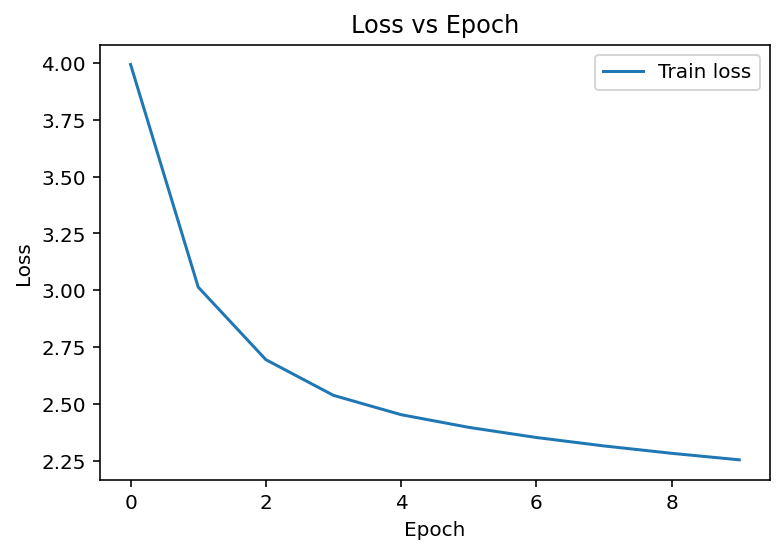

In [ ]:
plt.plot(train_loss_list, label = "Train loss")
#plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [36]:
# Testons le modèle
# Les unsqueeze permettent d'adapter les shape (avec un batch_size de 1)

# i un indice dans notre dataset
i = 0
y_input = dataset[i][0].unsqueeze(0).to(device)
tgt_mask = model.get_tgt_mask(y_input[0].size(0)).to(device)
pred = model(torch.tensor([0]*len(y_input[0])).unsqueeze(0).to(device), y_input, tgt_mask)
next_item = pred.topk(1)[1].view(-1)[-1].item()


In [37]:
# Le token prédit est ...
itos_vocab[next_item]

'n58'

In [38]:
r1 = [itos_vocab[v] for v in pred.topk(1)[1].view(-1)]
r1

['d1',
 'd1',
 't2',
 'n65',
 'd2',
 't2',
 'v113',
 'n62',
 'd2',
 't2',
 'v113',
 'n60',
 'd2',
 't1',
 'v108',
 'n58',
 'd2',
 't2',
 'v113',
 'n58',
 'd2',
 't2',
 'v113',
 'n58',
 'd2',
 't2',
 'v113',
 'n58',
 'd2',
 't2',
 't4',
 'n61',
 'd2',
 't2',
 'v113',
 'n58',
 'd1',
 't2',
 'v102',
 'n58',
 'd2',
 't2',
 'v113',
 'n58',
 'd1',
 't2',
 'v101',
 'n58',
 'd2',
 't2',
 'v101',
 'n58',
 'd2',
 't2',
 'v113',
 'n58',
 'd1',
 't2',
 'v112',
 'n58',
 'd1',
 't2',
 'v102',
 'n60',
 'd1',
 't2',
 'v102',
 'n58',
 'd1',
 't2',
 'v112',
 'n58',
 'd2',
 't2',
 'v102',
 'n60',
 'd1',
 't2',
 'v102',
 'n58',
 'd1',
 't2',
 'v102',
 'n62',
 'd2',
 't2',
 'v102',
 'n58',
 'd1',
 't2',
 'v114',
 'n58',
 'd2',
 't2',
 'v102',
 'n60',
 'd1',
 't2',
 'v102',
 'n58',
 'd2',
 't2',
 'v114',
 'n58',
 'd2',
 't2',
 'v114',
 'n60',
 'd2',
 't2',
 'v101',
 'n58',
 'd2',
 't2',
 'v114',
 'n58',
 'd1',
 't2',
 'v102',
 'n58']

In [ ]:
# La séquence donnée en entrée était ...
r2 = [itos_vocab[v] for v in y_input[0]]
r2

['BOS',
 'd3',
 't2',
 'v104',
 'n63',
 'd2',
 't4',
 'v114',
 'n58',
 'd2',
 't5',
 'v106',
 'n58',
 'd7',
 't4',
 'v98',
 'n50',
 'd2',
 't39',
 'v90',
 'n57',
 'd2',
 't4',
 'v113',
 'n60',
 'd1',
 't2',
 'v110',
 'n58',
 'd2',
 't1',
 'v111',
 'n55',
 'd1',
 't3',
 'v103',
 'n58',
 'd1',
 't3',
 'v106',
 'n61',
 'd4',
 't1',
 'v106',
 'n60',
 'd2',
 't5',
 'v112',
 'n58',
 'd1',
 't2',
 'v100',
 'n60',
 'd5',
 't2',
 'v105',
 'n58',
 'd2',
 't6',
 'v109',
 'n56',
 'd2',
 't2',
 'v107',
 'n60',
 'd2',
 't2',
 'v106',
 'n59',
 'd1',
 't2',
 'v101',
 'n57',
 'd1',
 't2',
 'v103',
 'n58',
 'd2',
 't1',
 'v111',
 'n54',
 'd2',
 't2',
 'v102',
 'n55',
 'd1',
 't2',
 'v97',
 'n58',
 'd1',
 't1',
 'v109',
 'n61',
 'd2',
 't1',
 'v107',
 'n56',
 'd1',
 't3',
 'v103',
 'n61',
 'd2',
 't1',
 'v113',
 'n62',
 'd1',
 't2',
 'v114',
 'n58',
 'd2',
 't2',
 'v110',
 'n60',
 'd2',
 't2',
 'v112',
 'n55',
 'd2',
 't2',
 'v107']

In [39]:
# Et la target
r3 = [itos_vocab[v] for v in dataset[i][1].unsqueeze(0).to(device)[0]]
r3

['n65',
 'd2',
 'v104',
 'n63',
 'd2',
 't4',
 'v109',
 'n58',
 'd1',
 't3',
 'v103',
 'n61',
 'd3',
 't2',
 'v104',
 'n63',
 'd2',
 't4',
 'v114',
 'n58',
 'd2',
 't5',
 'v106',
 'n58',
 'd7',
 't4',
 'v98',
 'n50',
 'd2',
 't39',
 'v90',
 'n57',
 'd2',
 't4',
 'v113',
 'n60',
 'd1',
 't2',
 'v110',
 'n58',
 'd2',
 't1',
 'v111',
 'n55',
 'd1',
 't3',
 'v103',
 'n58',
 'd1',
 't3',
 'v106',
 'n61',
 'd4',
 't1',
 'v106',
 'n60',
 'd2',
 't5',
 'v112',
 'n58',
 'd1',
 't2',
 'v100',
 'n60',
 'd5',
 't2',
 'v105',
 'n58',
 'd2',
 't6',
 'v109',
 'n56',
 'd2',
 't2',
 'v107',
 'n60',
 'd2',
 't2',
 'v106',
 'n59',
 'd1',
 't2',
 'v101',
 'n57',
 'd1',
 't2',
 'v103',
 'n58',
 'd2',
 't1',
 'v111',
 'n54',
 'd2',
 't2',
 'v102',
 'n55',
 'd1',
 't2',
 'v97',
 'n58',
 'd1',
 't1',
 'v109',
 'n61',
 'd2',
 't1',
 'v107',
 'n56',
 'd1',
 't3',
 'v103',
 'n61',
 'd2',
 't1',
 'v113',
 'n62',
 'd1',
 't2',
 'v114',
 'n58']

In [40]:
res = 0
for j in range(len(r1)):
    if (r1[j]==r3[j]):
        res +=1
print(res)

40


In [ ]:
# save the model to a file
torch.save(model.state_dict(), 'modeltest.pth')

In [ ]:
# save the datset arrays to a file
np.save('input_weimar_test.npy', input_vect)
np.save('rep_weimar_test.npy', rep_vect)

In [41]:
#sauver la prédiction

np.save('pred_test.npy', pred.topk(1)[1].view(-1).cpu())

In [42]:
#sauver la prédiction

np.save('morceau_test.npy', dataset[i][1])